# Terrorismo en Colombia 2010-2021

## Importación de librerías

In [6]:
!pip install geopandas xlrd==1.2.0 rarfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import geopandas as gpd
import re
import os
import matplotlib.pyplot as plt

import imageio
import rarfile

In [8]:
list_texts = [re.findall('^t\w+\.xls[x]?', i)[0] for i in os.listdir() if len(re.findall('^t\w+\.xls[x]?', i))!= 0]

## Importación de datos

In [9]:
list_dfs = [pd.read_excel(i, skiprows=9) for i in list_texts]
pob = pd.read_csv('/content/pob_2010_2021.csv')

In [10]:
with rarfile.RarFile('/content/MGN2021_MPIO_POLITICO.rar') as rf:
  for doc in rf.namelist():
    rf.extract(doc)

geo = gpd.read_file('/content/MGN_MPIO_POLITICO.shp')

## Limpieza de datos

In [ ]:
for idx, i in enumerate(list_dfs):
  df = i.copy()
  if 'Unna' in df.columns[0]:
    df.columns = df.iloc[0]
    df = df.drop(index=0).reset_index(drop=True)
    print(df)
  df = df.drop(index=df.iloc[-5:].index)
  list_dfs[idx] = df

In [12]:
for i in list_dfs:
  i.columns = i.columns.str.replace('*', ' ').str.strip().str.lower().str.replace(' ', '_')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


## Merge y enriquecimiento de datos

In [13]:
df = pd.concat(list_dfs, ignore_index=True)

In [20]:
df['fecha_año'] = pd.to_datetime(df['fecha_hecho'].astype(str)).dt.year
df['delito'] = 'terrorismo'
df['codigo_dane'] = (df['codigo_dane'].astype('int') / 1000).astype('int')

In [21]:
num_terror = df.pivot_table(index=['municipio', 'codigo_dane', 'fecha_año'],
               values='cantidad',
               aggfunc='sum').reset_index()

In [22]:
num_terr = num_terror.merge(pob, left_on=['codigo_dane', 'fecha_año'], right_on=['COD_MUNICIPIO', 'AÑO'], how='left')

In [23]:
num_terr['tasa_terrorismo'] = num_terr['cantidad'] / num_terr['Total'] * 100000
num_terr.columns = num_terr.columns.str.lower()
num_terr = num_terr.drop(columns=['cod_municipio', 'año', 'mpnom']).rename(columns={'total':'pob'})

## Limpieza de geoinfo


In [24]:
geo['MPIO_CDPMP'] = geo['MPIO_CDPMP'].astype(int)

In [25]:
geo_df = geo[['MPIO_CDPMP', 'geometry', 'MPIO_CNMBR']]

In [36]:
lista_dfs_geo = []
for year in num_terr['fecha_año'].unique():
  if year != 2022:
    df_prov = num_terr[num_terr['fecha_año'] == year]
    lista_dfs_geo.append(geo_df.merge(df_prov, left_on='MPIO_CDPMP', right_on='codigo_dane', how='left').assign(fecha_año=year))

## Merge

In [37]:
geo_terr = pd.concat(lista_dfs_geo)

In [38]:
geo_terr_not_na = geo_terr.dropna(subset=['fecha_año'])

In [39]:
terr_max = geo_terr['tasa_terrorismo'].max()
terr_min = geo_terr['tasa_terrorismo'].min()

## Creación de gráficas

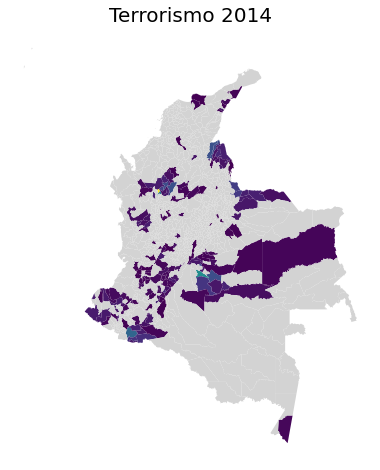

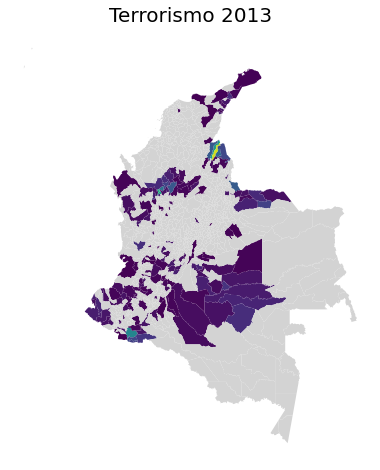

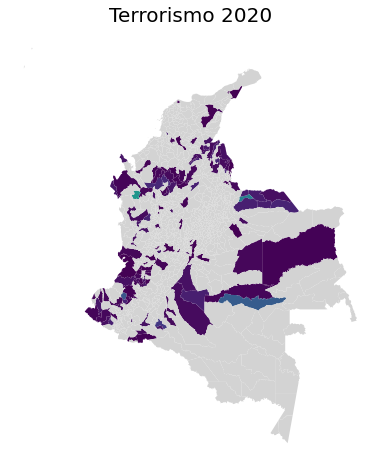

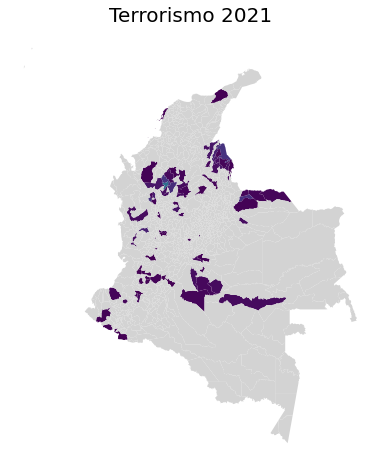

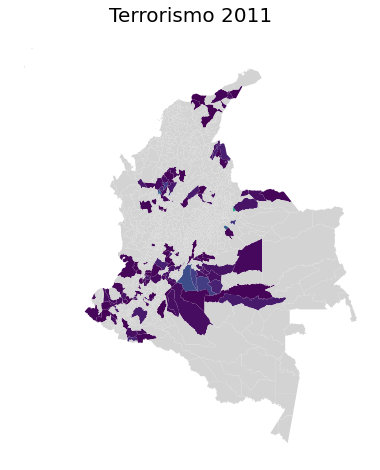

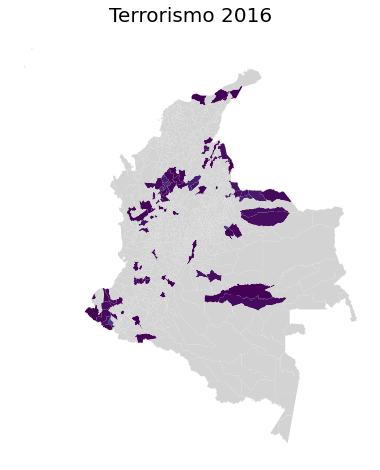

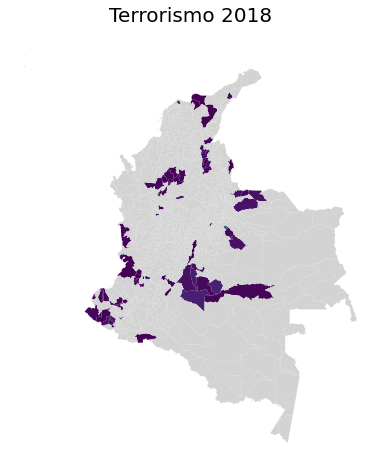

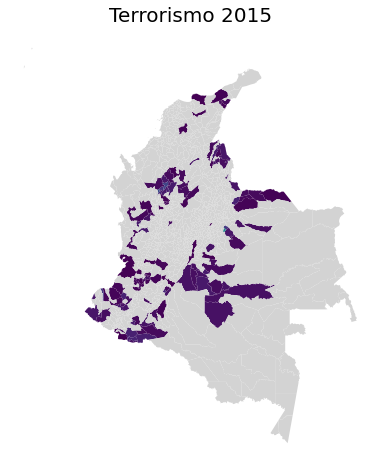

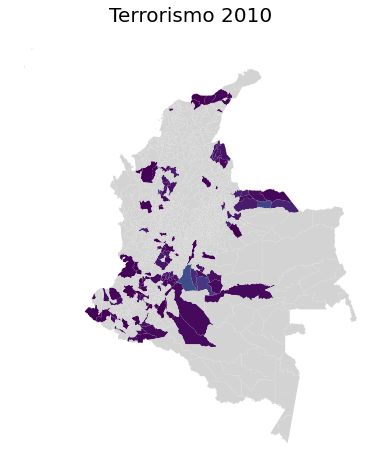

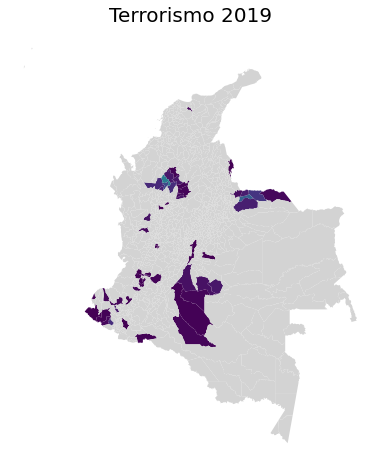

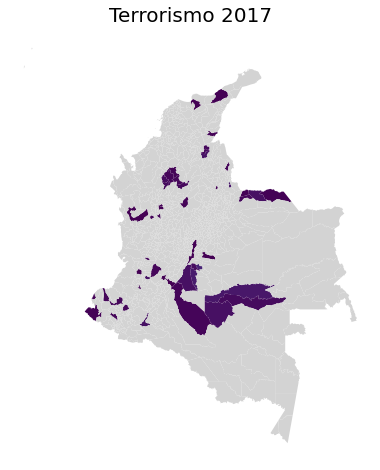

In [40]:
for fecha in geo_terr_not_na['fecha_año'].unique():
  geo_pas = geo_terr[geo_terr['fecha_año'] == fecha]

  fig, ax = plt.subplots(1, 1, figsize=(14, 8))
  geo_pas.plot('tasa_terrorismo', 
               figsize=(14, 8), 
               missing_kwds=dict(color = "lightgrey"),
               ax=ax, vmin=terr_min, vmax=terr_max)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.set_title(f'Terrorismo {int(fecha)}', size=20)
  plt.tick_params(left = False, bottom = False)
  ax.set_xticks([])
  ax.set_yticks([])
  fig.savefig(f'terrorismo{int(fecha)}.png')
  plt.show()

## Gif

In [41]:
imgs = [re.findall('^t\w+\.png', i)[0] for i in os.listdir() if len(re.findall('^t\w+\.png', i))>0 ]

imgs = sorted(imgs)
with imageio.get_writer('my_gif.gif', mode='I', fps=0.8) as writer:
  for filename in imgs:
    image = imageio.imread(filename)
    writer.append_data(image)

## Descarga de datos

In [42]:
num_terr.to_csv('terrorismo.csv', index=False)